In [7]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from functions import get_zone, load_360_data, get_progressive_actions, zone_polygon, plot_team_zone_shares

### Features to use

Main tactical features to use:
- Width offensivly ✅
- Directness
- Pass length
- Tempo
- Restförsvar ?
- Fasta situationer ?
- Press, triggers (defensiva aktioner i offensiv planhalva) (tid för bollvinst)
- Höjd på backlinje
- Antal progressiva passningar
- Bollhastighet
- Final third entries

### Game State:
- Which zone are we in?
- Distance to goal?
- Angle to goal?
- Opponents near?
- How many opponants near?
- Score?
-  Red cards?

### Tactics: 


In [8]:
def calc_width(df, match=True):
    df = df.copy()

    # enforce integer IDs early
    for c in ["match_id", "team_id"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64") 
    df["pass_width"] = abs(df["endy"] - 40)
    if match:
        match_width = (
            df.groupby(["match_id", "team_id"])["pass_width"]
            .mean()
            .reset_index(name="mean_width")
        )
        match_width["match_id"] = match_width["match_id"].astype("Int64")
        match_width["team_id"]  = match_width["team_id"].astype("Int64")
        return match_width

    team_width = (
        df.groupby(["team_id", "match_id"])["pass_width"]
        .mean()
        .groupby("team_id")
        .mean()
        .reset_index(name="mean_width")
    )
    team_width["team_id"] = team_width["team_id"].astype("Int64")
    return team_width

In [9]:
actions=("Pass", "Carry", "Dribble")
action_types_exclude = ["Throw-in", "Corner", "Free Kick", "Kick-off", "Goal Kick"]
df = load_360_data(actions, three_sixty_only=False)



#is_dead_ball_action = df["pass_type"].isin(action_types_exclude)


passes = get_progressive_actions(df=df)
prog_passes = passes[passes["is_progressive"] == True]



Loading events: 100%|██████████| 3464/3464 [02:55<00:00, 19.75it/s]


In [10]:
match_width = calc_width(prog_passes, match=True)
# This is a Series indexed by (match_id, team_id)
widest = match_width.loc[match_width["mean_width"].idxmax()]
most_central = match_width.loc[match_width["mean_width"].idxmin()]

print("Widest match:")
print(widest)

print("\nMost central match:")
print(most_central)


Widest match:
match_id      2275108.0
team_id           973.0
mean_width    28.739423
Name: 1627, dtype: Float64

Most central match:
match_id      3888719.0
team_id           781.0
mean_width    14.872993
Name: 5228, dtype: Float64


match_id      2275108.0
team_id           973.0
mean_width    28.739423
Name: 1627, dtype: Float64
match_id      3888719.0
team_id           781.0
mean_width    14.872993
Name: 5228, dtype: Float64


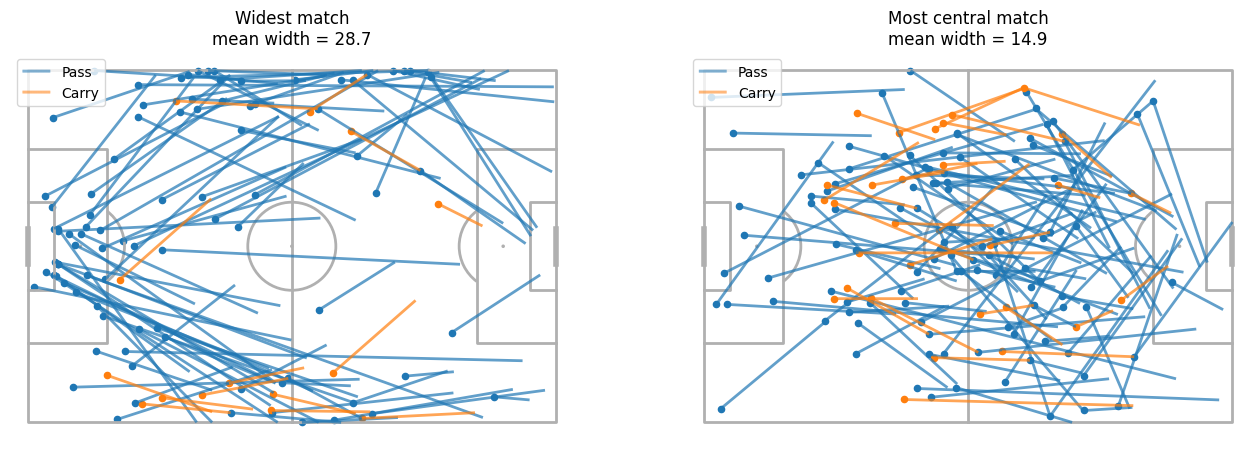

In [16]:


def plot_two_matches(df, a, b):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    pitch = Pitch(pitch_type="statsbomb", line_zorder=2)

    for ax, row, title in zip(
        axes,
        [a, b],
        ["Widest match", "Most central match"]
    ):
        pitch.draw(ax=ax)

        subset = df[
            (df["match_id"] == row["match_id"]) &
            (df["team_id"] == row["team_id"]) &
            (df["is_progressive"])
        ]

        passes  = subset[subset["type"] == "Pass"]
        carries = subset[subset["type"] == "Carry"]

        # --- passes (blue) ---
        pitch.lines(
            passes["x"], passes["y"],
            passes["endx"], passes["endy"],
            ax=ax,
            lw=2, alpha=0.7, color="tab:blue", label="Pass"
        )
        pitch.scatter(
            passes["x"], passes["y"],
            ax=ax, s=20, color="tab:blue"
        )

        # --- carries (orange) ---
        pitch.lines(
            carries["x"], carries["y"],
            carries["endx"], carries["endy"],
            ax=ax,
            lw=2, alpha=0.7, color="tab:orange", label="Carry"
        )
        pitch.scatter(
            carries["x"], carries["y"],
            ax=ax, s=20, color="tab:orange"
        )

        ax.set_title(f"{title}\nmean width = {row['mean_width']:.1f}")
        ax.legend(loc="upper left")

    plt.show()
assert "is_progressive" in prog_passes.columns
print(widest)
print(most_central)
plot_two_matches(prog_passes, widest, most_central)


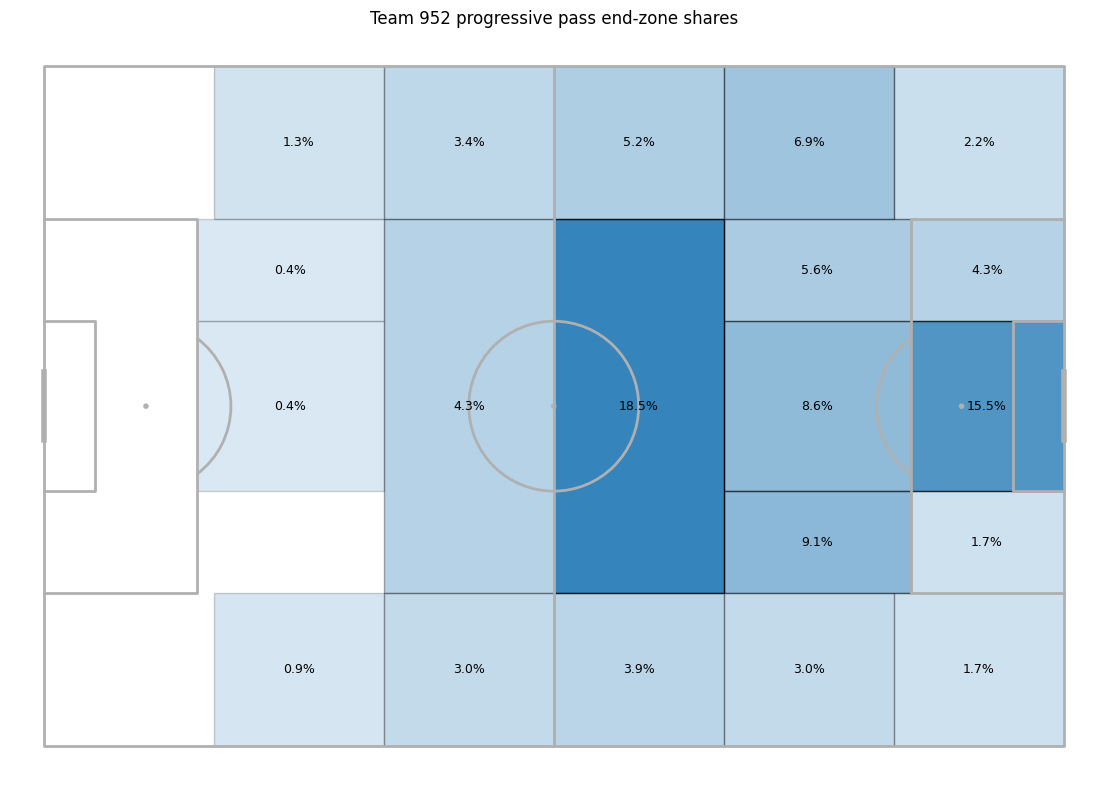

In [12]:
prog_passes = prog_passes.copy()
prog_passes["zone_end"] = prog_passes.apply(lambda r: get_zone(r["endx"], r["endy"]), axis=1)
counts = prog_passes.groupby(["team_id", "zone_end"]).size().rename("n").reset_index()

counts["share"] = counts["n"] / counts.groupby("team_id")["n"].transform("sum")

team_zone_share = counts[["team_id", "zone_end", "share"]]

plot_team_zone_shares(team_zone_share, team_id=952)

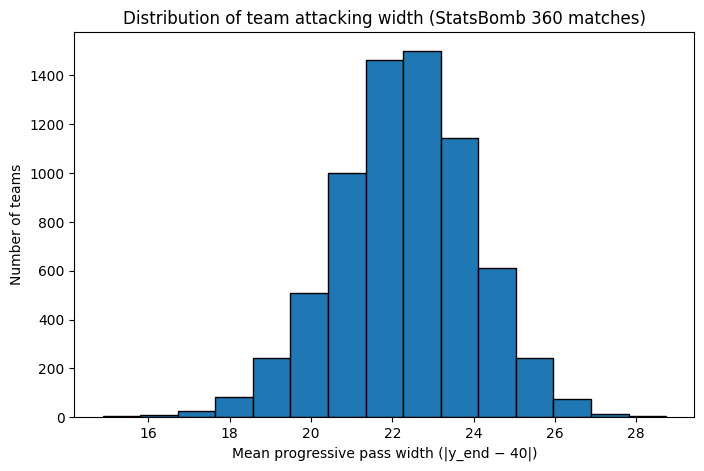

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(match_width["mean_width"], bins=15, edgecolor="black")
plt.xlabel("Mean progressive pass width (|y_end − 40|)")
plt.ylabel("Number of teams")
plt.title("Distribution of team attacking width (StatsBomb 360 matches)")
plt.show()

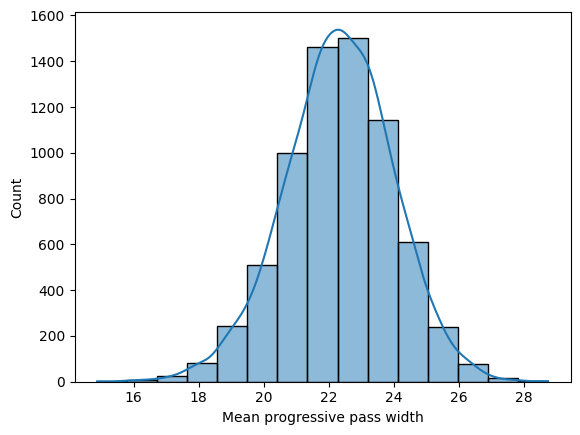

In [14]:
import seaborn as sns

sns.histplot(match_width["mean_width"], bins=15, kde=True)
plt.xlabel("Mean progressive pass width")
plt.show()


In [15]:
prog_passes["type"].value_counts(normalize=True)

type
Pass     0.820182
Carry    0.179818
Name: proportion, dtype: float64